# Implement Hessian Loss Landscapes

Ashley S. Dale

Notebook loads a pretrained ALIGNN model, and calculates the loss landscape using Hessian directions


- Relevant paper: [*Visualizing high-dimensional loss landscapes with Hessian directions* by Bottcher and Wheeler](https://iopscience.iop.org/article/10.1088/1742-5468/ad13fc/meta)

---
Notebook Outline:

0. Select and load trained model and data

0. Generate a set of predictions for the data

0. Select a subset of well predicted instances to be "In Distribution" (ID) based on the z-score of the prediction error, where low z-score represents well predicted and therefore in-distribution

0. Select a subset of poorly predicted instances to be "Out of Distribution" (OOD) based on the z-score of the prediction error, where a high z-score represents poorly predicted and therefore out-of-distribution

0. Load Hessian eigenvectors as two new models. These models will define the coordinate axes of the loss landscape

0. Calculate the loss landscape using the original model as the origin, and the models generated from the eigenvectors of the Hessian as the two directions in which the original model is perturbed. Repeat this twice for the ID and OOD datasets.


In [1]:
# For the hessian calculation, these additional packages should be installed
# !pip install torchdiffeq

In [1]:
import copy
import torch
import glob
import json

import numpy as np
from tqdm import tqdm
# import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

import ipywidgets as widgets
from torchinfo import summary
from pymatgen.core.periodic_table import Element
from collections import OrderedDict

import alignn
from alignn.pretrained import *
from jarvis.db.figshare import data
from jarvis.db.figshare import data
from jarvis.db.jsonutils import loadjson

import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

from src.utils import *

In [2]:
if torch. cuda. is_available():
    print("Using GPU ...")
    device = 'cuda'
else:
    device = 'cpu'

Using GPU ...


# Load Model

In [3]:
list_of_pretrained_models = list(get_all_models().keys())

-> Select the `jv_formation_energy_peratom_alignn` model for the demo

In [4]:
style = {'description_width': 'initial'}

config_selector = widgets.Dropdown(
    options=list_of_pretrained_models,
    value=list_of_pretrained_models[0],
    description='Select Model',
    style=style,
    disabled=False,
)

display(config_selector)

Dropdown(description='Select Model', options=('jv_formation_energy_peratom_alignn', 'jv_optb88vdw_total_energy…

In [5]:
# This is the model we will load
model_name = config_selector.value
print("Selected: ", model_name)

Selected:  jv_formation_energy_peratom_alignn


In [6]:
model = get_figshare_model(model_name)
model.to(device)
_ = model.eval()

Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path c:\Users\EthanH24\anaconda3\envs\losslandscapefeb8gpu4\lib\site-packages\alignn\jv_formation_energy_peratom_alignn.zip
Config c:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\jv_formation_energy_peratom_alignn\config.json


c:\Users\EthanH24\anaconda3\envs\losslandscapefeb8gpu4\lib\site-packages\alignn\pretrained.py:292: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

In [7]:
model_wt_dict = OrderedDict([i for i in model.named_parameters()])

In [8]:
summary(model)

Layer (type:depth-idx)                   Param #
ALIGNN                                   --
├─MLPLayer: 1-1                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  23,808
│    │    └─BatchNorm1d: 3-2             512
│    │    └─SiLU: 3-3                    --
├─Sequential: 1-2                        --
│    └─RBFExpansion: 2-2                 --
│    └─MLPLayer: 2-3                     --
│    │    └─Sequential: 3-4              5,312
│    └─MLPLayer: 2-4                     --
│    │    └─Sequential: 3-5              17,152
├─Sequential: 1-3                        --
│    └─RBFExpansion: 2-5                 --
│    └─MLPLayer: 2-6                     --
│    │    └─Sequential: 3-6              2,752
│    └─MLPLayer: 2-7                     --
│    │    └─Sequential: 3-7              17,152
├─ModuleList: 1-4                        --
│    └─ALIGNNConv: 2-8                   --
│    │    └─EdgeGatedGraphConv: 3-8      329,984
│  

# Load Data

In [9]:
# target = 'optb88vdw_bandgap'
target = 'formation_energy_peratom'
n_samples = 1000
element_to_omit_from_training_data = 'Fe'

In [10]:
d = data("dft_3d")
d = d[:n_samples]
dataset = DataFrame(copy.deepcopy(d))
atoms_df = DataFrame(list(DataFrame(d)['atoms']))
dataset = pd.concat([dataset, atoms_df], axis=1)
train_idx, test_idx = get_split(dataset, 'elements', element_to_omit_from_training_data)
print('num train samples: '+ str(len(train_idx)))
print('num test samples: '+ str(len(test_idx)))

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
num train samples: 927
num test samples: 73


# Predicting on Test and Train Data

split all samples based having or not having Fe

In [12]:
train_data = [d[idx] for idx in train_idx.to_list()]
train_dataloader = get_data_loader(train_data, target, workers=0)

model_train_predictions = []
original_train_targets = []
for s in tqdm(train_dataloader):
    original_train_targets.append(s[2].detach().numpy()[0])
    y_pred = model([s[0].to(device), s[1].to(device)])
    y_pred = np.expand_dims(y_pred.cpu().detach().numpy(), axis=0)[0]
    model_train_predictions.append(y_pred)

data range 5.28308 -4.0858
Converting to graphs!


100%|██████████| 927/927 [00:06<00:00, 137.68it/s]


df                                                  atoms     prop  jid
0    {'lattice_mat': [[3.566933224304235, 0.0, -0.0... -0.42762    0
1    {'lattice_mat': [[4.089078911208881, 0.0, 0.0]... -0.41596    1
2    {'lattice_mat': [[-1.833590720595598, 1.833590...  0.04847    2
3    {'lattice_mat': [[7.2963518353359165, 0.0, 0.0... -0.44140    3
4    {'lattice_mat': [[1.6777483798834445, -2.90594... -0.71026    4
..                                                 ...      ...  ...
922  {'lattice_mat': [[0.0, 5.004301514431302, 5.00...  1.16087  922
923  {'lattice_mat': [[4.496207811888019, 0.0, 0.0]... -1.90267  923
924  {'lattice_mat': [[0.0, 3.852051785372815, 3.85...  0.41960  924
925  {'lattice_mat': [[0.0, 4.9082744345175895, 4.9...  0.49906  925
926  {'lattice_mat': [[0.0, 4.920264584239658, 4.92...  0.92931  926

[927 rows x 3 columns]
building line graphs


100%|██████████| 927/927 [00:22<00:00, 40.93it/s]


In [13]:
test_data = [d[idx] for idx in test_idx.to_list()]
test_dataloader = get_data_loader(test_data, target, workers=0)

model_test_predictions = []
original_test_targets = []
for s in tqdm(test_dataloader):
    original_test_targets.append(s[2].detach().numpy()[0])
    y_pred = model([s[0].to(device), s[1].to(device)])
    y_pred = np.expand_dims(y_pred.cpu().detach().numpy(), axis=0)[0]
    model_test_predictions.append(y_pred)


data range 1.56755 -2.65468
Converting to graphs!


100%|██████████| 73/73 [00:00<00:00, 131.43it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[4.927781968323723, -0.0, 0.0... -1.78124   1
2   {'lattice_mat': [[4.839493559425439, 9.7116505... -1.66274   2
3   {'lattice_mat': [[5.464512229851642, 0.0, -2.0... -0.93989   3
4   {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   4
..                                                ...      ...  ..
68  {'lattice_mat': [[4.8166458682114435, -0.0, 0.... -1.28488  68
69  {'lattice_mat': [[0.0, 4.589959301088131, 0.00... -1.70084  69
70  {'lattice_mat': [[3.4709209595661688, -1.12804... -0.19524  70
71  {'lattice_mat': [[-0.0, 3.24316049942265, 3.24...  0.14577  71
72  {'lattice_mat': [[6.84938891863269, 1.15896e-1... -0.44277  72

[73 rows x 3 columns]
building line graphs


100%|██████████| 73/73 [00:01<00:00, 38.57it/s]


## Subselect Train Data Samples: Most ID (Minimum Error)

In [14]:
num_sample_in_loader = 50 #choose the number of samples involved in hessian computation and loss landscape visualization

In [15]:
train_df = pd.DataFrame(train_data)
train_df['pred_val'] = model_train_predictions
train_df['err'] = (train_df[target] - train_df['pred_val'])
train_df['abs_err'] = np.abs(train_df[target] - train_df['pred_val'])
train_df['z_score_err'] = (train_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])
train_df.head()

,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,pred_val,err,abs_err,z_score_err
0,JVASP-90856,129,P4/nmm,TiCuSiAs,-0.42762,OptB88vdW,0.000,"{'lattice_mat': [[3.566933224304235, 0.0, -0.0...",na,0.0,...,na,na,na,na,mp-1080455,-As-Cu-Si-Ti,-0.429359,0.001739,0.001739,-0.188278
1,JVASP-86097,221,Pm-3m,DyB6,-0.41596,OptB88vdW,0.000,"{'lattice_mat': [[4.089078911208881, 0.0, 0.0]...",na,0.0,...,na,na,na,na,mp-568319,-B-Dy,-0.417615,0.001655,0.001655,-0.190158
2,JVASP-64906,119,I-4m2,Be2OsRu,0.04847,OptB88vdW,0.000,"{'lattice_mat': [[-1.833590720595598, 1.833590...",na,0.0,...,na,na,na,na,auid-3eaf68dd483bf4f4,-Be-Os-Ru,0.046013,0.002457,0.002457,-0.172129
3,JVASP-98225,14,P2_1/c,KBi,-0.44140,OptB88vdW,0.472,"{'lattice_mat': [[7.2963518353359165, 0.0, 0.0...",na,0.0,...,na,na,na,na,mp-31104,-Bi-K,-0.444024,0.002624,0.002624,-0.168389
4,JVASP-10,164,P-3m1,VSe2,-0.71026,OptB88vdW,0.000,"{'lattice_mat': [[1.6777483798834445, -2.90594...",na,0.0,...,48.79,33.05,0.0,na,mp-694,-Se-V,-0.713197,0.002937,0.002937,-0.161357


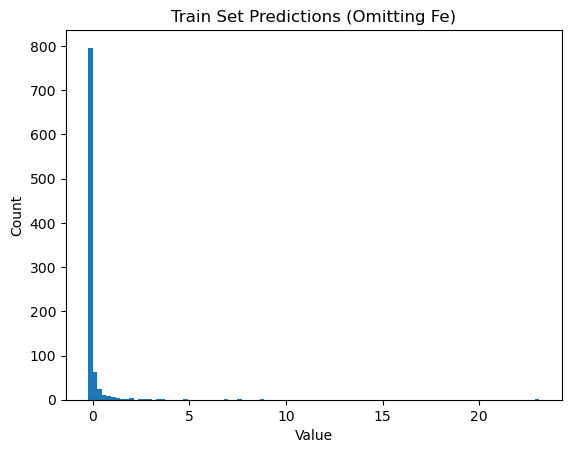

In [16]:
ax = plt.hist(train_df['z_score_err'].values, bins=100)
plt.title('Train Set Predictions (Omitting '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [49]:
#select samples with minimal error
train_subset_df = train_df.nsmallest(num_sample_in_loader, 'z_score_err')
train_subset_df_idx = train_subset_df.index.values.tolist()
train_subset_list = [train_data[i] for i in train_subset_df_idx]
train_subset_dataloader = get_data_loader(train_subset_list, target, workers=4)
train_subset_df.head() #contains the ids of train sub-selected samples

data range 1.31171 -3.24073
Converting to graphs!


100%|██████████| 50/50 [00:00<00:00, 132.54it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[5.614561710069512, -0.008098... -3.04140   0
1   {'lattice_mat': [[4.428712142345245, 0.0938283... -1.15984   1
2   {'lattice_mat': [[6.077481786895317, 0.0, 0.0]... -0.84152   2
3   {'lattice_mat': [[7.542839764249747, 0.1718970... -0.44498   3
4   {'lattice_mat': [[5.382597739169287, 0.0, -0.0... -2.65345   4
5   {'lattice_mat': [[5.341766494740965, 4.8168425... -0.56058   5
6   {'lattice_mat': [[3.413342172498346, 0.0, 0.0]... -1.42034   6
7   {'lattice_mat': [[4.328319117003372, 1.032103e... -1.67055   7
8   {'lattice_mat': [[5.995433144500313, 0.0005096... -0.39732   8
9   {'lattice_mat': [[4.452327579413091, -0.007614... -1.46129   9
10  {'lattice_mat': [[3.8371322574431592, 0.0, 0.0...  0.04698  10
11  {'lattice_mat': [[3.4021647857751227, -3.63769... -3.08561  11
12  {'lattice_mat': [[0.0, 4.897127193355007, 4.89...  0.29936  12
13  {'lattice_mat': [[3.751609782599518, -0.0, -0....  0.28

100%|██████████| 50/50 [00:00<00:00, 1657.87it/s]


,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,pred_val,err,abs_err,z_score_err
716,JVASP-98452,2,P-1,K2Ca3Si3O10,-3.04140,OptB88vdW,4.228,"{'lattice_mat': [[5.614561710069512, -0.008098...",na,0.0,...,na,na,na,na,mp-1019747,-Ca-K-O-Si,-3.041397,-0.000003,0.000003,-0.227288
906,JVASP-86159,8,Cm,Ca3SiBr2,-1.15984,OptB88vdW,0.000,"{'lattice_mat': [[4.428712142345245, 0.0938283...",na,0.0,...,na,na,0.0,na,mp-568791,-Br-Ca-Si,-1.159848,0.000008,0.000008,-0.227182
219,JVASP-85713,26,Pmc2_1,LiHS,-0.84152,OptB88vdW,3.501,"{'lattice_mat': [[6.077481786895317, 0.0, 0.0]...",na,0.0,...,23.69,5.55,na,na,mp-644419,-H-Li-S,-0.841544,0.000024,0.000024,-0.226805
475,JVASP-5503,2,P-1,TeAuCl7,-0.44498,OptB88vdW,1.466,"{'lattice_mat': [[7.542839764249747, 0.1718970...",20.29,0.0,...,na,na,2.126,na,mp-28330,-Au-Cl-Te,-0.445009,0.000029,0.000029,-0.226706
696,JVASP-97814,62,Pnma,Sn2BF7,-2.65345,OptB88vdW,4.390,"{'lattice_mat': [[5.382597739169287, 0.0, -0.0...",na,0.0,...,na,na,na,na,mp-27430,-B-F-Sn,-2.653481,0.000031,0.000031,-0.226656


In [19]:
#load train subset to dataloader
subset_train_x = []
subset_train_y = []

for i in train_subset_dataloader:
    subset_train_x.append((i[0], i[1]))
    subset_train_y.append(i[2])

## Subselect Test Samples - Most OOD (Maximum Error)

In [20]:
test_df = pd.DataFrame(test_data)
test_df['pred_val'] = model_test_predictions
test_df['err'] = (test_df[target] - test_df['pred_val'])
test_df['abs_err'] = np.abs(test_df[target] - test_df['pred_val'])
test_df['z_score_err'] = (test_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [21]:
test_subset_df = test_df.nlargest(num_sample_in_loader, 'z_score_err')
test_subset_df_idx = test_subset_df.index.values.tolist()
test_subset_list = [test_data[i] for i in test_subset_df_idx]
test_subset_dataloader = get_data_loader(test_subset_list, target, workers=4)
test_subset_df.head()

data range 1.56755 -2.4227
Converting to graphs!


100%|██████████| 50/50 [00:00<00:00, 102.20it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[0.0, 4.897056811995578, 4.89...  1.53929   1
2   {'lattice_mat': [[4.110215016104089, 0.0, 0.0]... -0.04638   2
3   {'lattice_mat': [[2.848077488322179, 2.8480774... -0.10758   3
4   {'lattice_mat': [[4.1657904284125715, 4.165790... -0.04919   4
5   {'lattice_mat': [[2.920865223038774, 2.9208652... -0.34463   5
6   {'lattice_mat': [[-0.0, 5.137906744010782, 5.1...  1.00634   6
7   {'lattice_mat': [[-0.0, 4.907221750514012, 4.9...  0.85838   7
8   {'lattice_mat': [[3.903902177836003, 0.0, 0.0]... -1.20482   8
9   {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   9
10  {'lattice_mat': [[3.0998966569685593, 0.0, 0.0... -1.88091  10
11  {'lattice_mat': [[8.144256654569737, -0.0, 0.0... -1.34337  11
12  {'lattice_mat': [[4.811567551604352, 0.0, 0.0]... -1.96675  12
13  {'lattice_mat': [[-0.0, 3.24316049942265, 3.24...  0.14

100%|██████████| 50/50 [00:00<00:00, 2221.16it/s]


,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,pred_val,err,abs_err,z_score_err
0,JVASP-22556,221,Pm-3m,SrFeO3,-2.07159,OptB88vdW,0.0,"{'lattice_mat': [[3.790914410660539, -0.0, 0.0...",na,na,...,na,na,na,na,mp-510624,-Fe-O-Sr,-2.227911,0.156321,0.156321,3.285762
64,JVASP-64061,216,F-43m,Ba4MnFe,1.53929,OptB88vdW,0.0,"{'lattice_mat': [[0.0, 4.897056811995578, 4.89...",na,3.045,...,na,na,na,na,auid-b652221ff5797705,-Ba-Fe-Mn,1.635016,-0.095726,0.095726,1.923969
12,JVASP-91848,65,Cmmm,LaFe5H2,-0.04638,OptB88vdW,0.0,"{'lattice_mat': [[4.110215016104089, 0.0, 0.0]...",na,na,...,na,na,na,na,mp-24813,-Fe-H-La,0.030191,-0.076571,0.076571,1.493482
42,JVASP-37190,216,F-43m,MnGaFeCo,-0.10758,OptB88vdW,0.0,"{'lattice_mat': [[2.848077488322179, 2.8480774...",na,3.068,...,203.33,26.42,0.0,na,mp-999552,-Co-Fe-Ga-Mn,-0.153370,0.045790,0.045790,0.801710
52,JVASP-90438,122,I-42d,FeAgSe2,-0.04919,OptB88vdW,0.0,"{'lattice_mat': [[4.1657904284125715, 4.165790...",na,6.736,...,na,na,na,na,mp-1096959,-Ag-Fe-Se,-0.081389,0.032199,0.032199,0.496276


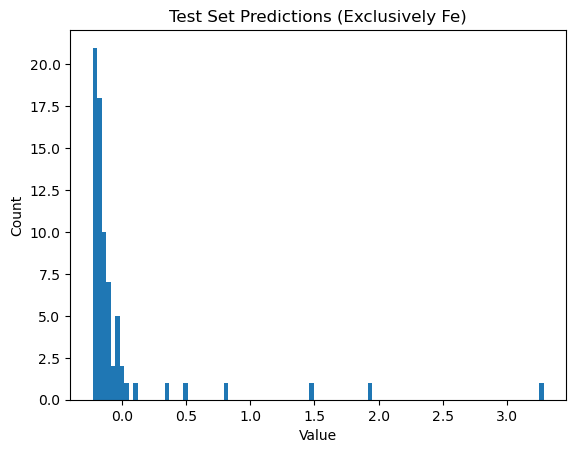

In [22]:
ax = plt.hist(test_df['z_score_err'].values, bins=100,)
plt.title('Test Set Predictions (Exclusively '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

## Loading and Formatting Eigenvectors from saved local file

In [26]:
### Defaults from OG implementation
loss_func = torch.nn.MSELoss()
func = copy.deepcopy(model)
og_params = [i[1] for i in func.named_parameters() if len(i[1].size()) > 1]
og_layer_names = [i[0] for i in func.named_parameters() if len(i[1].size())>1]

In [27]:
model_eig_max = copy.deepcopy(func)
model_eig_max.load_state_dict(torch.load('model_eig_max.pt', weights_only=True))
model_eig_min = copy.deepcopy(func)
model_eig_min.load_state_dict(torch.load('model_eig_min.pt', weights_only=True))

<All keys matched successfully>

# Create 2D Directed Loss Surface

In [28]:
import loss_landscapes
import loss_landscapes.metrics

from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

specifie resolution

In [35]:
STEPS = 30

In [36]:
# This is the custom model wrapper for the loss landscapes calculation
class Metric(ABC):
    """ A quantity that can be computed given a model or an agent. """

    def __init__(self):
        super().__init__()

    @abstractmethod
    def __call__(self, model_wrapper: ModelWrapper):
        pass

class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, model, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.model = model
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        outputs = model_wrapper.forward(self.inputs)
        err = self.loss_fn(self.target[0], outputs)
        return err

for each sample in dataloader, compute losslandscape, and saves to a list

todo: 
- test on two versions of perturbation:
1. Direction = [eigenvector-original_weight], which is the original implementation
2. Direction = [eigenvector], need to adjust the function

In [37]:
train_loss_landscapes_list = []
for i, batch in tqdm(enumerate(train_subset_dataloader), total=len(train_subset_dataloader)):
    x_train = (batch[0].to(device), batch[1].to(device))
    y_train = (batch[2].to(device))
    metric = Loss(loss_func, func.eval(), x_train, y_train)

    # print('True', float(y_train))
    # print('Predicted',float(model(x_train)))
    # print('MSE',np.abs((float(y_train)-float(model(x_train))))**2)
    # print('metric', metric(func.eval()))

    try:
        loss_data_fin = loss_landscapes.planar_interpolation(
            model_start=func.eval(), 
            model_end_one=model_eig_max.eval(),
            model_end_two=model_eig_min.eval(),
            metric=metric, steps=STEPS, deepcopy_model=True
            )
        ## TODO: ugly patch to convert array from torch.tensors to np.array
        tmp_ll = []
        for row in loss_data_fin:
            tmp_row = []
            for itm in row:
                tmp_row.append(itm.detach().cpu().numpy())
            tmp_ll.append(tmp_row)
    except Exception as e:
        print(e+'batch id: '+str(i))
        # continue
    train_loss_landscapes_list.append(np.expand_dims(np.array(tmp_ll), axis=2))


100%|██████████| 50/50 [22:12<00:00, 26.66s/it]


computes average and standard deviation of the loss landscape array

In [ ]:
tmp = np.concatenate(train_loss_landscapes_list, axis=2) 
avg_loss_landscape = np.mean(tmp, axis=2) #averaging the loss landscape for all samples
std_loss_landscape = np.std(tmp, axis=2)

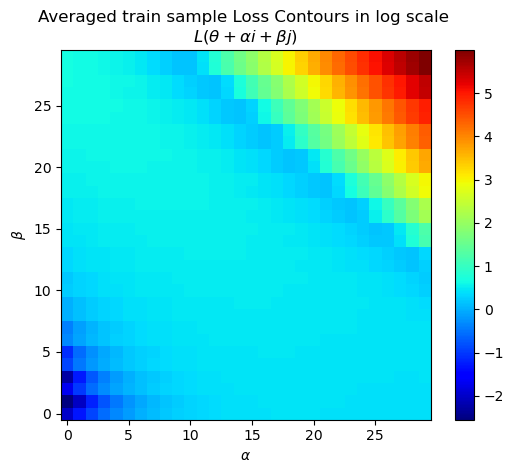

In [39]:
save_fig_name = os.path.join('loss_contours_train.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log10(avg_loss_landscape), cmap='jet', origin='lower')
ax.set_title('Averaged train sample Loss Contours in log scale \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
#fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

In [40]:
test_loss_landscapes_list = []
for i, batch in tqdm(enumerate(test_subset_dataloader), total=len(test_subset_dataloader)):
    x_train = (batch[0].to(device), batch[1].to(device))
    y_train = (batch[2].to(device))
    metric = Loss(loss_func, func.eval(), x_train, y_train) #actually x_test,y_test but named differently
    try:
        loss_data_fin = loss_landscapes.planar_interpolation(
            model_start=func.eval(), 
            model_end_one=model_eig_max.eval(),
            model_end_two=model_eig_min.eval(),
            metric=metric, steps=STEPS, deepcopy_model=True
            )
        ## TODO: ugly patch to convert array from torch.tensors to np.array
        tmp_ll = []
        for row in loss_data_fin:
            tmp_row = []
            for itm in row:
                tmp_row.append(itm.detach().cpu().numpy())
            tmp_ll.append(tmp_row)

    except Exception as e:
        print(e+'batch id: '+str(i)) 
        # continue
    test_loss_landscapes_list.append(np.expand_dims(np.array(tmp_ll), axis=2))

100%|██████████| 50/50 [18:20<00:00, 22.01s/it]


computes average and standard deviation of the loss landscape array

In [41]:
tmp = np.concatenate(test_loss_landscapes_list, axis=2)
test_avg_loss_landscape = np.mean(tmp, axis=2)
test_std_loss_landscape = np.std(tmp, axis=2)

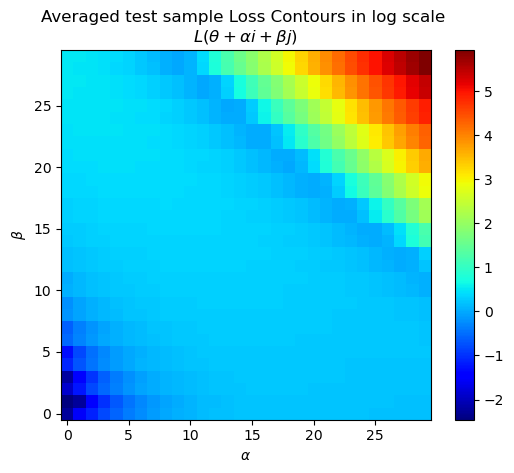

In [ ]:
save_fig_name = os.path.join('loss_contours_test.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log10(test_avg_loss_landscape), cmap='jet', origin='lower')
ax.set_title('Averaged test sample Loss Contours in log scale \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
#fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

### Saving outputs

If STEPS, loss function, or training subset are changed, then start in a new folder.

In [64]:
import os
import datetime

_=input('Create a new folder to save?')

def initialize_save(output_data, base_path,comment):
    # Create a timestamp for the folder name
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"output_{timestamp}_"+comment
    folder_path = os.path.join(base_path, folder_name)

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

    # Create a text file in the folder
    file_name = "parameters.txt"
    file_path = os.path.join(folder_path, file_name)

    # Save the output data to the text file
    with open(file_path, 'w') as f:
        f.write(output_data)
    
    print(f"Output saved to: {file_path}")

    return folder_path

def save_dfs_to_csv(train_df, test_df, base_path):
    # Create a timestamp for the folder name
    folder_path = base_path

    # Save the DataFrames to CSV files
    train_csv_path = os.path.join(folder_path, "train_subset.csv")
    test_csv_path = os.path.join(folder_path, "test_subset.csv")

    train_df.to_csv(train_csv_path, index=False)
    test_df.to_csv(test_csv_path, index=False)

    print(f"Train subset saved to: {train_csv_path}")
    print(f"Test subset saved to: {test_csv_path}")
# Example usage
output_data = (
    f'Model name = {model_name}\n'
    f'STEPS = {STEPS}\n'
    f'Loss function = {loss_func}\n'
    f'# Train subset = {len(train_subset_df)}\n'
    f'# Test subset = {len(test_subset_df)}'
)
base_path = r"C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs"  # Specify your base path here

new_folder_path = initialize_save(output_data, base_path,'dir=eigenvec-starting_point')

save_dfs_to_csv(train_subset_df, test_subset_df, new_folder_path)

Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point
Output saved to: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\parameters.txt
Train subset saved to: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_subset.csv
Test subset saved to: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\test_subset.csv


for train loss landscape in train loss landscape list:
    index the training sample in train subset df
    create a folder named df['jid']

    save the training sample in train subset df in txt

    save train loss landscape in txt
    save train loss landscape png
    save the output data

In [75]:
def save_loss_landscapes(train_or_test, loss_landscape_list, train_subset_df, folder_path):

    for i, loss_landscape in enumerate(loss_landscape_list):
        # Index the training sample in train_subset_df
        sample_index = i  # Assuming the index corresponds to the loss landscape
        sample_data = train_subset_df.iloc[sample_index]

        # Create a folder named df['jid']
        jid_folder = os.path.join(folder_path, train_or_test+str(sample_data['jid']))
        if not os.path.exists(jid_folder):
            os.makedirs(jid_folder)
            print(f"Created folder: {jid_folder}")

         # Save the training sample in train_subset_df as a CSV file
        sample_csv_path = os.path.join(jid_folder, train_or_test+str(sample_data['jid'])+"sample_data.csv")
        sample_data.to_frame().T.to_csv(sample_csv_path, index=False)  # Convert Series to DataFrame and save

         # Save train loss landscape in a text file
        loss_txt_path = os.path.join(jid_folder, train_or_test+str(sample_data['jid'])+"loss_landscape.txt")

        # Check the shape of the loss_landscape and handle accordingly
        if loss_landscape.ndim == 3:
            # Flatten the 3D array to 1D
            loss_landscape = loss_landscape.flatten()
        elif loss_landscape.ndim > 2:
            # If it's still more than 2D, reshape it to 2D
            loss_landscape = loss_landscape.reshape(-1, loss_landscape.shape[-1])  # Reshape to 2D

        np.savetxt(loss_txt_path, loss_landscape)


        save_fig_name = os.path.join(jid_folder,train_or_test+str(sample_data['jid'])+'_loss_contours.png')
        fig, ax = plt.subplots(1, 1)
        plt.imshow(np.log10(avg_loss_landscape), cmap='jet', origin='lower')
        ax.set_title(str(sample_data['jid'])+ 'Sample Loss Contours in log scale \n'+ r'$L(\theta + \alpha i + \beta j$)')
        ax.set_xlabel(r'$\alpha$')
        ax.set_ylabel(r'$\beta$')
        plt.colorbar()
        fig.savefig(save_fig_name, transparent=True, dpi=300)
        plt.close()

        save_fig_name = os.path.join(folder_path,train_or_test+str(sample_data['jid'])+'_loss_contours.png')
        fig, ax = plt.subplots(1, 1)
        plt.imshow(np.log10(avg_loss_landscape), cmap='jet', origin='lower')
        ax.set_title(str(sample_data['jid'])+ 'Sample Loss Contours in log scale \n'+ r'$L(\theta + \alpha i + \beta j$)')
        ax.set_xlabel(r'$\alpha$')
        ax.set_ylabel(r'$\beta$')
        plt.colorbar()
        fig.savefig(save_fig_name, transparent=True, dpi=300)
        plt.close()

        # Save the output data (if needed)
        output_txt_path = os.path.join(jid_folder, train_or_test+str(sample_data['jid'])+"output_data.txt")
        with open(output_txt_path, 'w') as f:
            f.write(output_data)

# Example usage
folder_path = new_folder_path
save_loss_landscapes('train_', loss_landscapes_list, train_subset_df, folder_path)

Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_JVASP-98452
Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_JVASP-86159
Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_JVASP-85713
Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_JVASP-5503
Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_JVASP-97814
Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output_20250211_015643_dir=eigenvec-starting_point\train_JVASP-22645
Created folder: C:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\outputs\output

In [82]:
loss_landscapes_list[0]

array([[[3.64943817e-02],
        [1.73224762e-01],
        [4.58339393e-01],
        [9.39110458e-01],
        [1.65574598e+00],
        [2.54458213e+00],
        [3.54086280e+00],
        [4.57160902e+00],
        [5.56869125e+00],
        [6.47152185e+00],
        [7.19717693e+00],
        [7.77484560e+00],
        [8.23243332e+00],
        [8.58737087e+00],
        [8.85250282e+00],
        [9.03963852e+00],
        [9.16111946e+00],
        [9.22918510e+00],
        [9.25475979e+00],
        [9.24693394e+00],
        [9.21312618e+00],
        [9.15955353e+00],
        [9.09173679e+00],
        [9.01494217e+00],
        [8.93455219e+00],
        [8.85634899e+00],
        [8.78664970e+00],
        [8.73225594e+00],
        [8.70025921e+00],
        [8.69784451e+00]],

       [[9.83804092e-03],
        [2.67637018e-02],
        [2.12170497e-01],
        [6.20129824e-01],
        [1.29839623e+00],
        [2.18550181e+00],
        [3.20897746e+00],
        [4.28885460e+00],
        [5

In [83]:
loss_landscapes_list[0].reshape(-1, loss_landscapes_list[0].shape[-1])

array([[3.64943817e-02],
       [1.73224762e-01],
       [4.58339393e-01],
       [9.39110458e-01],
       [1.65574598e+00],
       [2.54458213e+00],
       [3.54086280e+00],
       [4.57160902e+00],
       [5.56869125e+00],
       [6.47152185e+00],
       [7.19717693e+00],
       [7.77484560e+00],
       [8.23243332e+00],
       [8.58737087e+00],
       [8.85250282e+00],
       [9.03963852e+00],
       [9.16111946e+00],
       [9.22918510e+00],
       [9.25475979e+00],
       [9.24693394e+00],
       [9.21312618e+00],
       [9.15955353e+00],
       [9.09173679e+00],
       [9.01494217e+00],
       [8.93455219e+00],
       [8.85634899e+00],
       [8.78664970e+00],
       [8.73225594e+00],
       [8.70025921e+00],
       [8.69784451e+00],
       [9.83804092e-03],
       [2.67637018e-02],
       [2.12170497e-01],
       [6.20129824e-01],
       [1.29839623e+00],
       [2.18550181e+00],
       [3.20897746e+00],
       [4.28885460e+00],
       [5.34736300e+00],
       [6.31371689e+00],
